# Passage Retrieval - Dense Embedding

* Dense Embeddind : Sparse Embeddind의 단점을 극복함

## 1. Introduction to Dense Embedding

* Passage Embedding
  * 구절(Passage)을 벡터로 변환하는 것

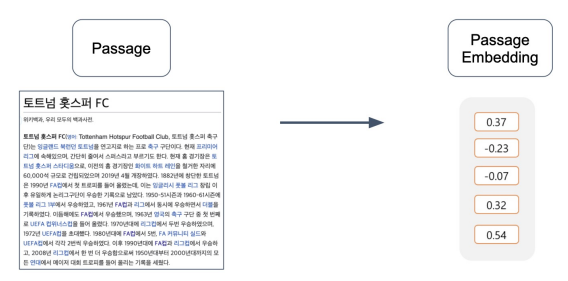

* Sparse Embedding
  * TF-IDF 벡터는 sparse 함
  * 벡터의 크기는 크지만 0이 아닌 숫자는 상당히 적음
    * BoW 방법론을 채택하고 있기 때문에 특정 단어가 있는 경우에만 해당 vocab의 dimension이 non-zero가 됨으로써, 사실상 90% 이상의 dimension들이 0이 되는 경우가 발생함

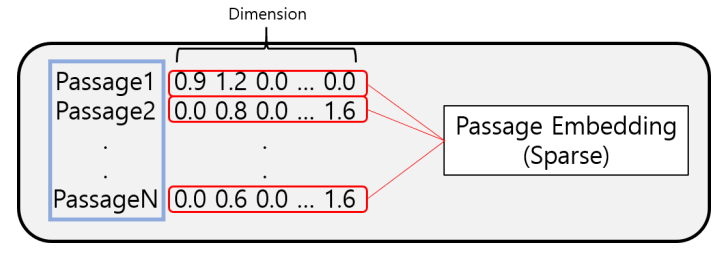

* Limitations of sparse embedding
  1. 차원의 수가 매우 큼 -> compressed format으로 극복 가능함
    * non-zero의 위치와 값만 저장하여 vector전체를 저장하지 않는 대신 efficient하게 저장 가능함
  2. 유사성을 고려하지 못함
    * 두 단어가 비슷한 의미를 가져도 vector space에서 완전히 다른 dimension을 차지하고, vector space에서 유사성을 전혀 고려할 수 없음

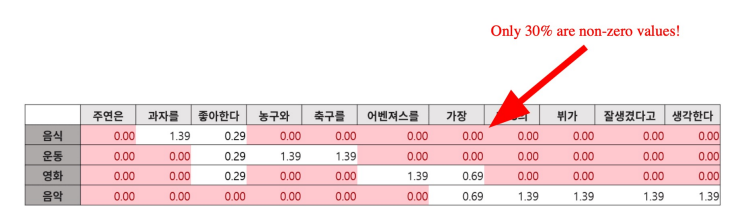

* Dense Embedding 이란?
  * Completementary to sparse representations by design
    * 더 작은 차원의 고밀도 벡터 (length = 50-1000)
      * 1000이상으로 올라가는 경우는 거의 없음
    * 각 차원이 특정 term에 대응되지 않음
      * 차원이 모두 더해져서 vector space상의 위치가 의미를 나타내도록 복합적이고 부분적인 의미를 가짐
    * 대부분의 요소가 non-zero 값
      * 의미가 있는 값을 가짐
  * sparse embedding 보다 많이 사용됨

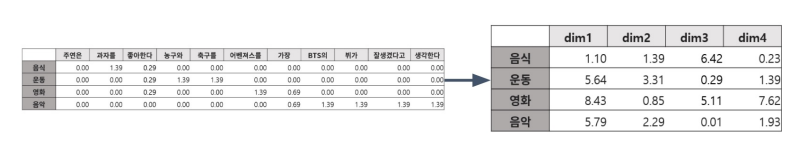

* Retrieval: Sparse vs Dense
  * Sparse
    * 단어의 존재 유뮤 확인할 때 유용하지만 의미적으로 해석하기 어려움
    * dimension dense가 크기 때문에 활용할 수 있는 알고리즘에 한계가 있음
  * Dense
    * 의미적으로 같지만 다른 단어들을 detect할 수 있음
    * dimension이 작기 때문에 활용할 수 있는 알고리즘이 많음

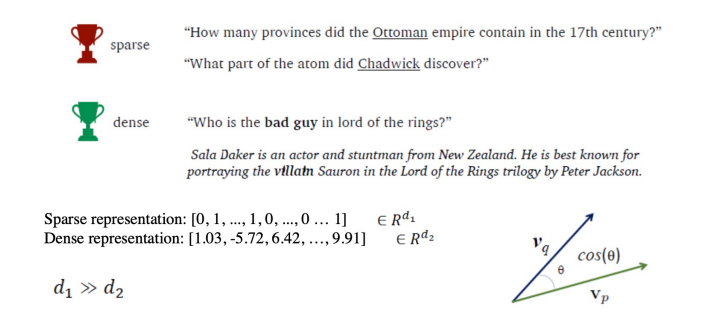

* 현업에서 Sparse Embedding이 많이 쓰이지만 sparse embedding만으로 많은 것을 하기 어려움
  * 일반적으로 Sparse embedding과 Dense embedding가 동시에 쓰이거나, Dense embedding 만 사용하여 retriever를 구축함

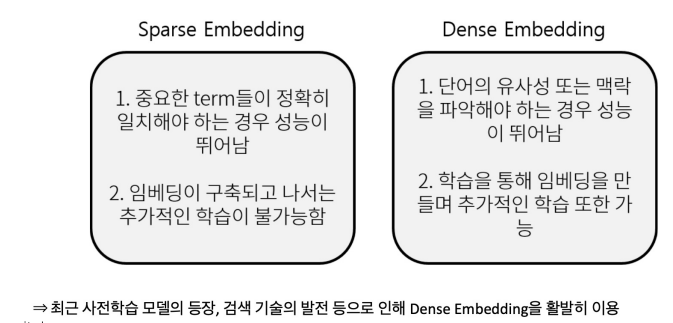

* Overview of Passage Retrieval with Dense Embedding
  * Encoder : BERT
    * BERT_Q : question 이 들어오면 sentence를 encoding하여 [CLS] token에 해당되는 vector를 보고 그 embedding을 h_q vector를 내보냄
    * BERT_B : passage 가 들어오면 encoding하여 [CLS] token 에 해당되는 vector를 보고 그 embedding을 h_b vector를 내보냄
    * h_q 와 h_b 는 같은 size이므로 유사도(현재 question과 특정 passage에 대한 유사도) 측정 가능
      * dot product : 유사도를 측정하는 가장 기본적인 방법
      * h_q의 transpose한 값과 h_b를 dot product하여 scalar value를 구함
      * 모든 passage에 대해 유사도를 측정하는 경우, 각각의 passage에 대한 유사도를 계산한 후 가장 높은 점수를 가지는 passage를 MRC 모델에 활용함

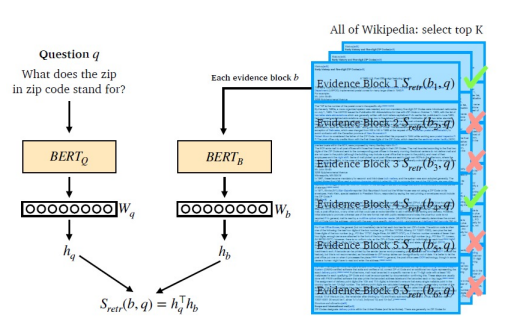

* BERT_Q 와 BERT_B가 같은 경우도 있음(동일한 encoder 사용)
  * 서로 다른 encoder를 사용하더라도 architecturally는 동일함

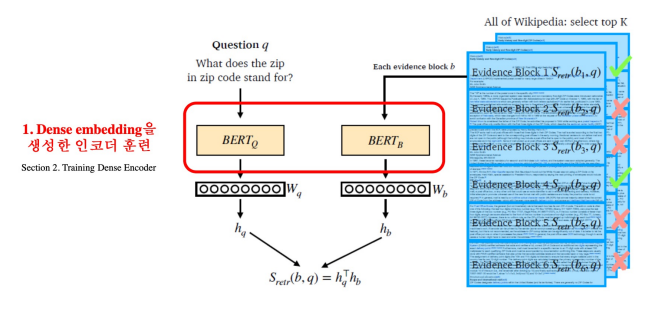

* 두 개의 output을 비교하여 score를 내는 방법으로 가장 유사한 문서를 찾음

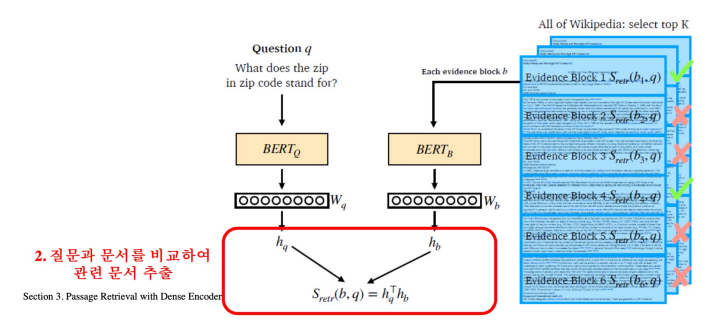

## 2. Training Dense Encoder

* What can be Dense Encoder?
  * BERT와 같은 Pre-trained language model (PLM)이 자주 사용됨
    * fine-tuning해서 활용가능함
    * BERT를 사용한 방법은 MRC와 유사함
  * 그 외에 다양한 neural network 구조도 가능함

* MRC와 BERT의 차이점차이점
        * MRC는 passage와 question을 같이 input으로 넣어준 반면, BERT는 passage와 question을 독립적으로 input으로 넣어줌(각각의 embedding을 구함)
        * MRC는 passage 내에서 answer의 위치를 예측하기 위해 각 token 별로 score를 내는것이 목적인 반면, BERT는 embedding을 output하는 것이 목적이기 때문에 [CLS] token의 최종 embedding을 output하여 passage를 encoding함
        * question도 동일한 방식으로 encoding함. design choice 보고 같은 parameter를 사용할지 별개의 parameter를 사용할지 선택함

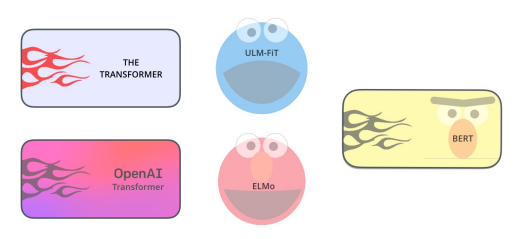

* What can be Dense Encoder?
  * BERT as dense encoder -> [CLS] token의 output 사용

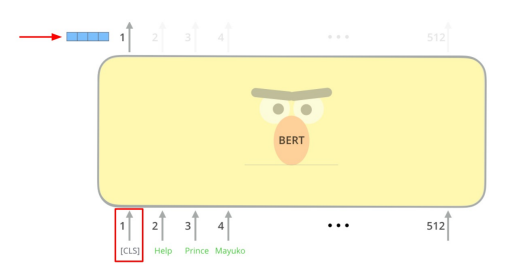

* Dense Encoder 구조
  * 학습시에는 BERT를 fine-tuning하여 실제 정답인 passage인 경우 유사도 점수가 더 높도록 학습하고, 정답이 아닌 passage인 경우 유사도 점수가 최대한 마이너스(-) 쪽으로 갈 수 있도록 학습하여 최종적으로 모델을 완성함

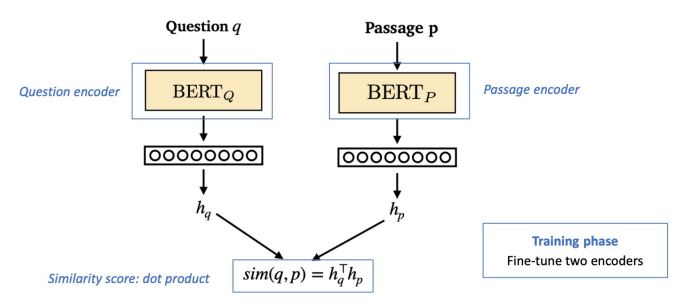

* Dense Encoder 학습 목표와 학습 데이터
  * 학습 목표 : 연관된 question 과 passage dense embedding 간의 거리를 좁히는 것 (또는 inner product를 높이는 것). 즉 higher similarity.
    * space에서 거리를 좁히는 쪽으로 간다면 nearest neighbor라고 볼 수 있음
  * Clallenge: 연관된 question / passage 를 어떻게 찾을 것인가? -> 기존 MRC 데이터셋 활용
    * 데이터셋에 있는 question과 passage pair는 정답 set으로 볼 수 있고, 그 외의 passage들은 관련이 없다고 볼 수 있음
    * 관련이 없는 passage들을 sample하기 위해서는 random하게 sample해오고 관련이 있는 passage는 question이 속해있는 passage를 사용하여 한쪽은 거리를 좁히고, 한쪽은 거리를 멀리하는 방식으로 학습을 진행함

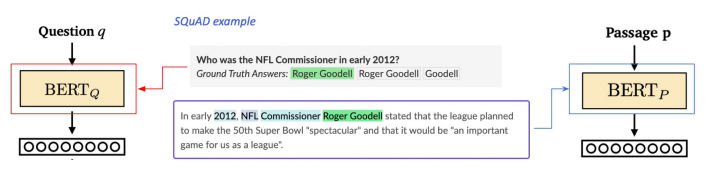

* Dense Encoder 학습 목표와 학습 데이터 - Negative Sampling
  1. 연관된 question 과 passage 간의 dense embedding 거리를 좁히는 것 (higher similarity) => **Positive**
  2. 연관 되지 않은 question과 passage 간의 embedding 거리는 멀어야 함 => **Negative**

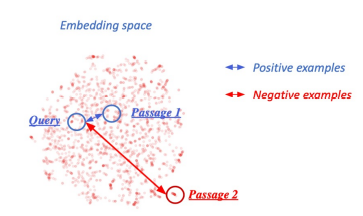

* Dense Encoder 학습 목표와 학습 데이터 - Negative Sampling
  * Choosing negative examples:
    1. Corpus 내에서 랜덤하게 뽑기
    2. 좀 더 헷갈리는 negative 샘플들 뽑기 (ex. 높은 TF-IDF 스코어를 가지지만 답을 포함하지 않는 샘플)

* Objective function
  * Positive passage 에 대한 negative log likelihood (NLL) loss 사용
  * similarity score(real number)와 negative sample의 점수를 softmax하여 확률값을 NLL에 적용하여 학습함
  * loss를 compute하는 방법(question, positive passage, negative passsage)
    * negative, log, softmax(분자 : positive score, 분모 : negative score, positive score)를 함

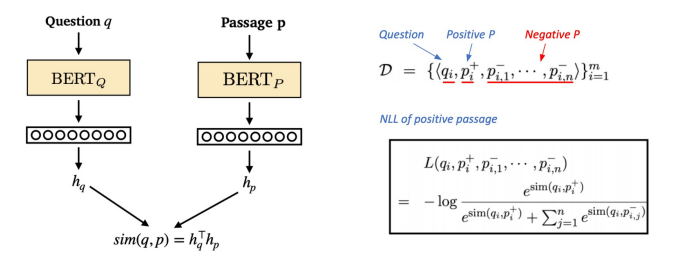

* Evaluation Metric for Dense Encoder
  * retriever의 성능을 측정하는 방법
  * Top-k retireval accuracy: retrieve 된 passage 중에 답을 포함하는 passage의 비율

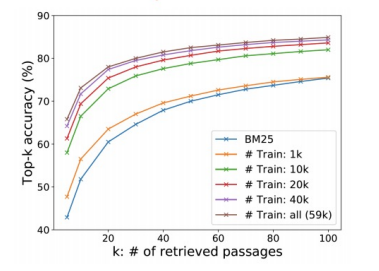

## 3. Passage Retrieval with Dense Encoder

* From dense encoding to retrieval
  * Inference: Passage와 query를 각각 embedding한 후, query로부터 가까운 순서대로 passage의 순위를 매김

  * 여러 passage를 각각 embedding한 후 compute함. 효율을 위해 corpus를 offline에 저장해놓음
  * question이 들어올 때마다 저장해놓은 passage vector와 query vector의 거리를 측정하거나 inner product를 계산하고, 가장 유사도가 높은 passage를 돌려줌

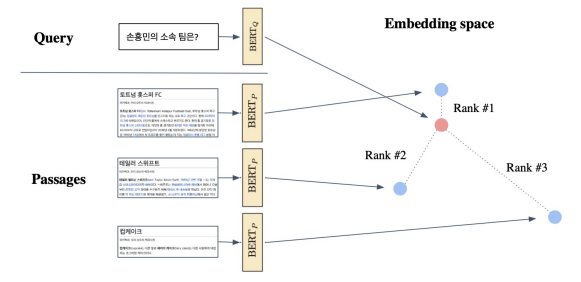

* From retrieval to open-domain question answering
  * Retriever를 통해 찾아낸 Passage을 활용, MRC (Machine Reading Comprehension) 모델로 답을 찾음

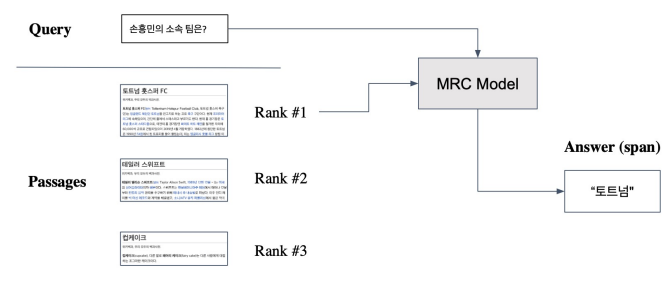

* How to make better dense encoding
  * 학습 방법 개선 (e.g. DPR)
  * 인코더 모델 개선 (BERT보다 큰, 정확한 Pretrained 모델)
  * 데이터 개선 (더 많은 데이터, 전처리 등)